In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [17]:
class Implementation:
    """Stores configuration details for a specific code implementation, device, and execution settings."""
    def __init__(self, name: str, device: str, cores: int):
        self.name = name
        self.device = device
        self.cores = cores

    def __repr__(self):
        return (f"Implementation(name='{self.name}', device='{self.device}', "
                f"cores={self.cores})")

In [18]:
class SpeedupComparison:
    """Stores a pair of Implementation objects for a single subplot comparison."""
    def __init__(self, new_impl: Implementation, baseline_impl: Implementation):
        self.new_impl = new_impl
        self.baseline_impl = baseline_impl

    def __repr__(self):
        return (f"SpeedupComparison(new={self.new_impl.name} ({self.new_impl.device}), "
                f"baseline={self.baseline_impl.name} ({self.baseline_impl.device}))")

In [19]:
def get_dataframe(dataset, invariant, implementation_name,
                  num_directions, num_timesteps, device, cores):
    csv_path = f"../results_tempest/{dataset}/{invariant}/{implementation_name}/" + \
        f"{num_directions}_dirs_{num_timesteps}_timesteps_{device}"
    
    if invariant == "ecf":
        csv_path += f"_{cores}_cores"
    
    csv_path += ".csv"

    return pd.read_csv(csv_path)

implementation_map = {
    "pyECT_uncompiled": "pyECT",
    "pyECT_compiled": "pyECT Compiled",
    "fast_topology": "FastTopology",
}

dataset_map = {
    "fashionmnist": "Fashion-MNIST",
    "imagenet": "ImageNet",
    "3D_cc_images": "3DCCs",
}

device_map = {
    "cpu": "CPU",
    "cuda": "GPU",
}

def plot_speedup_vs_cores_panel(
    datasets_list: list[str],
    num_timesteps: int,
    cores_baseline_list: list[int],
    comparisons_list: list[SpeedupComparison],
    grid_shape: tuple[int, int],
    show_err_bars: bool = True,
    fix_axes: bool = True,
    show_title: bool = True,
):
    """
    Creates a panel of speedup plots (vs. baseline cores). 
    Each subplot compares two implementations. 
    Lines within each subplot represent different datasets.

    Assumes invariant="ecf" and num_dirs=0 (fixed parameters for this plot type).
    """

    invariant = "ecf"
    num_dirs = 0

    num_rows, num_cols = grid_shape
    num_plots = num_rows * num_cols

    if len(comparisons_list) > num_plots:
        print(f"Warning: {len(comparisons_list)} comparisons provided, but grid only fits {num_plots}. Excess comparisons will be ignored.")
        comparisons_list = comparisons_list[:num_plots]
    
    # Create the figure and all subplots, sharing Y-axis for consistency
    fig, axes = plt.subplots(num_rows, num_cols, 
                             figsize=(7 * num_cols, 4 * num_rows), 
                             sharex=True, 
                             sharey=fix_axes)
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten() if num_plots > 1 else np.array([axes])
    
    # Loop through all comparisons to create subplots
    for ax_idx, comparison in enumerate(comparisons_list):
        ax = axes[ax_idx]
        new_impl = comparison.new_impl
        baseline_impl = comparison.baseline_impl

        # --- Subplot Logic: Loop through datasets for lines ---
        for dataset in datasets_list:
            mean_speedups = []
            std_speedups = []

            # Loop through the x-axis variable (cores_baseline_list)
            for cores_baseline in cores_baseline_list:

                # Load data for the new method (cores_new is fixed)
                df_new = get_dataframe(
                    dataset, invariant, new_impl.name,
                    num_dirs, num_timesteps, new_impl.device, new_impl.cores
                )

                # Load data for the baseline method (cores_baseline varies)
                df_baseline = get_dataframe(
                    dataset, invariant, baseline_impl.name,
                    num_dirs, num_timesteps, baseline_impl.device, cores_baseline
                )

                # Alignment and Speedup Calculation
                if df_new.empty or df_baseline.empty:
                    # Skip if data is missing for either
                    continue

                df = df_new.merge(
                    df_baseline, on="image_index", 
                    suffixes=("_new", "_baseline")
                )
                
                if not df.empty:
                    # Speedup = Baseline Time / New Implementation Time
                    per_image_speedup = df["computation_time_baseline"] / df["computation_time_new"]

                    mean_speedups.append(per_image_speedup.mean())
                    std_speedups.append(per_image_speedup.std())

            # Plot with error bars on the current axis
            if mean_speedups:
                ax.errorbar(
                    cores_baseline_list[:len(mean_speedups)],
                    mean_speedups,
                    yerr=std_speedups if show_err_bars else None,
                    marker="o",
                    capsize=4,
                    label=f"{dataset_map[dataset]}" # Label by dataset name
                )

        # --- Subplot Formatting ---
        
        # Plot y=1 line
        ax.axhline(y=1, color='r', linestyle='--', linewidth=1, alpha=0.7)
        
        # Set titles and labels
        if show_title:
            ax.set_title(f"{implementation_map[baseline_impl.name]} ({device_map[baseline_impl.device]}) vs {implementation_map[new_impl.name]} ({device_map[new_impl.device]})", fontsize=14)
        
        # Only label the Y-axis on the first column
        if ax_idx % num_cols == 0:
             ax.set_ylabel("Avg Speedup", fontsize=12)
             
        ax.set_xlabel(f"Number of Cores ({implementation_map[baseline_impl.name]})", fontsize=12)
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.legend(title="Datasets", fontsize=12, title_fontsize=12)
        ax.tick_params(labelsize=12)


    # Hide any unused subplots
    for i in range(len(comparisons_list), num_plots):
        fig.delaxes(axes[i])
        
    # Ensure proper spacing between subplots
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(f"figs/{invariant}_{'_'.join([str(c).replace(' ', '') for c in comparisons_list])}.pdf")
    plt.show()

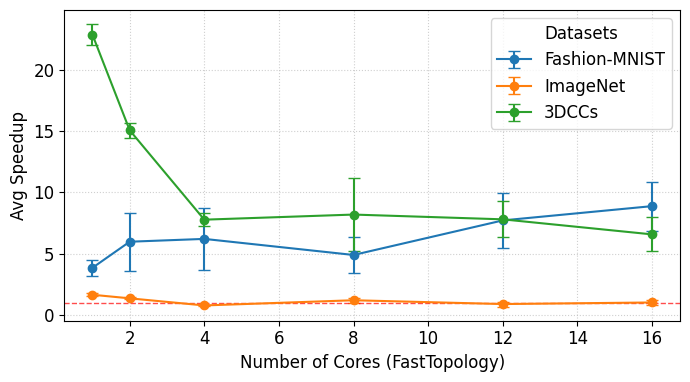

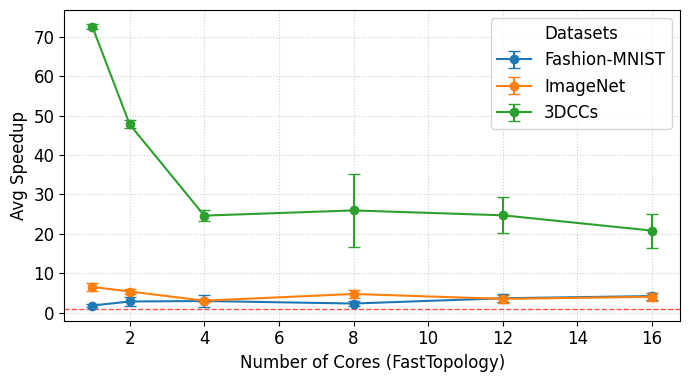

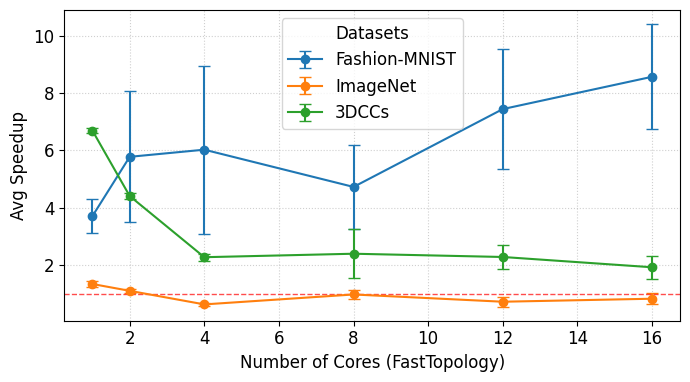

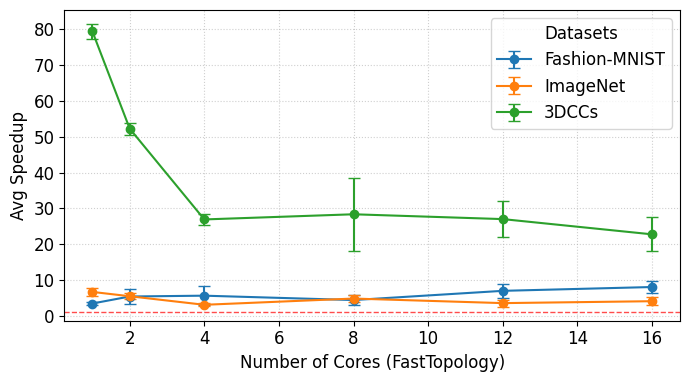

In [20]:
impl_pyECT_cpu = Implementation(name="pyECT_uncompiled", device="cpu", cores=1)
impl_pyECT_gpu = Implementation(name="pyECT_uncompiled", device="cuda", cores=1)
impl_pyECT_compiled_cpu = Implementation(name="pyECT_compiled", device="cpu", cores=1)
impl_pyECT_compiled_gpu = Implementation(name="pyECT_compiled", device="cuda", cores=1)
impl_fast_topology = Implementation(name="fast_topology", device="cpu", cores=1) # The cores will vary in the loop

comparisons = [
    SpeedupComparison(new_impl=impl_pyECT_cpu, baseline_impl=impl_fast_topology), 
    SpeedupComparison(new_impl=impl_pyECT_gpu, baseline_impl=impl_fast_topology),
    SpeedupComparison(new_impl=impl_pyECT_compiled_cpu, baseline_impl=impl_fast_topology), 
    SpeedupComparison(new_impl=impl_pyECT_compiled_gpu, baseline_impl=impl_fast_topology),
]

grid_shape = (1, 1)
datasets_to_plot = ["fashionmnist", "imagenet", "3D_cc_images"] # New parameter for lines
fixed_timesteps = 255
variable_cores = [1, 2, 4, 8, 12, 16] # X-axis

for comparison in comparisons:
    plot_speedup_vs_cores_panel(
        datasets_to_plot,
        fixed_timesteps,
        variable_cores,
        [comparison],
        grid_shape,
        fix_axes=False,
        show_title=False
    )
